In [46]:
import numpy as np
from scipy.spatial.distance import cdist
import numbers
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor, Pool
%matplotlib inline

In [2]:
data = pd.read_csv('1111.csv', parse_dates=True)

In [3]:
data.head()

,Скважина,Дата,ГТМ,Метод,Характер работы,Состояние,"Время работы, ч",Время накопления,"Нефть, т","Попутный газ, м3",...,Пластовое давление начальное,Характеристический дебит жидкости,Время в работе,Время в накоплении,ГП - Забойное давление,ГП(ИДН) Дебит жидкости,ГП(ИДН) Дебит жидкости скорр-ый,ГП(ИДН) Прирост дефита нефти,ГП(ГРП) Дебит жидкости,ГП(ГРП) Дебит жидкости скорр-ый
0,53514b4c4150ad897d82dd7d42cfc1a5,2012-03-30,0.0,ЭЦН/ФОН,НЕФ,РАБ.,301.0,0.0,"278,55",10028.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53514b4c4150ad897d82dd7d42cfc1a5,2012-04-30,0.0,ЭЦН,НЕФ,РАБ.,720.0,0.0,"1074,74",38690.0,...,231.0,847.308443,0.0,0.0,35.0,96.493251,96.493251,6.061904,363.692491,363.692491
2,53514b4c4150ad897d82dd7d42cfc1a5,2012-05-30,0.0,ЭЦН,НЕФ,РАБ.,744.0,0.0,"1046,80",37685.0,...,231.0,590.462454,0.0,0.0,36.0,65.665158,65.665158,1.483960,272.727847,272.727847
3,53514b4c4150ad897d82dd7d42cfc1a5,2012-06-30,0.0,ЭЦН,НЕФ,РАБ.,744.0,0.0,"900,95",32434.0,...,231.0,644.968860,0.0,0.0,35.4,53.838648,53.838648,0.510737,218.225582,218.225582
4,53514b4c4150ad897d82dd7d42cfc1a5,2012-07-31,0.0,ЭЦН,НЕФ,РАБ.,720.0,0.0,"761,72",27422.0,...,231.0,583.248775,0.0,0.0,37.6,47.981737,47.981737,0.640583,199.966616,199.966616


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3357 entries, 0 to 3356
Columns: 115 entries, Скважина to ГП(ГРП) Дебит жидкости скорр-ый
dtypes: float64(82), object(33)
memory usage: 2.9+ MB


Набор данных включает 115 атрибутов, 82 вещественных атрибута и 33 категориальных.  
**Задача - построение регрессионной модели с целью прогоноза переменной 'Нефть, т'. Метрика качества - Mean Absolute Error (MAE)**

In [ ]:
data['Нефть, т'].hist(bins=100)

## I. Преобразование и очистка данных

Проанализируем наличие отсутствующих значение в прогнозируемой переменной 'Нефть, т'. В случае наличия пропусков удалим эти записи из набора данных

In [5]:
data["Нефть, т"] = data["Нефть, т"].str.replace(",",".").astype(float)
sum(np.isnan(data["Нефть, т"]))

461

461 запись из 3357 не содержит значения прогнозируемой переменной

In [6]:
data = data[np.isfinite(data["Нефть, т"])]
data = data.reset_index(drop=True)

Выполним преобразование ряда атрибутов к корректному типу данных

In [7]:
data["Дата"] = pd.to_datetime(data["Дата"])
data["Обводненность (вес), %"] = data["Обводненность (вес), %"].str.replace(",",".").astype(float)
data["Приемистость, м3/сут"] = data["Приемистость, м3/сут"].str.replace(",",".").astype(float)
data["Добыча растворенного газа, м3"] = data["Добыча растворенного газа, м3"].str.replace(",",".").astype(float)
data["Дебит попутного газа, м3/сут"] = data["Дебит попутного газа, м3/сут"].str.replace(",",".").astype(float)
data["Конденсат, т"] = data["Конденсат, т"].str.replace(",",".").astype(float)
data["Дебит конденсата"] = data["Дебит конденсата"].str.replace(",",".").astype(float)

Проанализируем полноту и целостность данных с использованием инструмента pandas-profiling.  
Данный инструмент выполняет комплексный анализ данных на предмет пропусков, поиска константных и коллинеарных признаков

In [8]:
profile = ProfileReport(data)
rejected_vars = profile.get_rejected_variables()
rejected_vars

['Вязкость жидкости в пласт. условиях',
 'ГП(ГРП) Дебит жидкости',
 'ГП(ГРП) Дебит жидкости скорр-ый',
 'ГП(ИДН) Дебит жидкости',
 'ГП(ИДН) Дебит жидкости скорр-ый',
 'Глубина спуска доп. оборудования',
 'Дата ввода в эксплуатацию',
 'Дата запуска после КРС',
 'Дата останова',
 'Дата пуска',
 'Дебит попутного газа, м3/сут',
 'Добыча растворенного газа, м3',
 'Плотность нефти']

Удалим из набора данных константные и коллинеарные признаки

In [9]:
data = data.drop(columns=rejected_vars)
data = data.drop(columns=['Конденсат, т', 'Дебит конденсата', 'Фирма ГРП', 'Тип газосепаратора', 'Станок-качалка', 'Природный газ, м3', 'Газ из газовой шапки, м3',
                          'Коэффициент сепарации', 'Вязкость воды в пластовых условиях', 'Радиус контура питания', 'Фонтан через насос', 'Число качаний ШГН',
                         'Длина хода плунжера ШГН', 'Диаметр плунжера', 'Коэффициент подачи насоса', 'КН закрепленный'])

Признаки 'Причина простоя' и 'Агент закачки' содержат дубликаты значений, записанные с ошибками и в разных регистрах, необходимо привести значения к единому знаменателю

In [10]:
duplicates_p = {"ОСВОЕНИЕ ПОСЛЕ БУРЕНИЯ": "Освоение после бурения",
             "ПРИНЯТА В ОСВОЕНИЕ": "Принята в освоение",
             "НЕТ ПРИЕМИСТОСТИ": "Нет приемистости",
             "ПЕРЕВОД В ППД" : "Перевод в ППД"}
for key, value in duplicates_p.items():
    data.loc[data["Причина простоя"] == key,"Причина простоя"] = value

In [11]:
duplicates_a = {"Вода подтоварная,м.куб.,": "Вода подтоварная,м.куб."}
for key, value in duplicates_a.items():
    data.loc[data["Агент закачки"] == key,"Агент закачки"] = value

## II. Обработка категориальных признаков и заполнение пропусков

Пропуски в категориальных признаках заполним в 2 фазы:  
- модальное значение признака по записям в рамках одной скважины;  
- модальное значение для признака в целом по выборке.

In [12]:
# вариант с заполнением модой по скважине и по атрибуту
cat_features_indices = np.where(data.dtypes == 'object')[0]
cat_features_names = data.columns[cat_features_indices]
for i in data['Скважина'].unique():
    for j in cat_features_names:
        if data.loc[data['Скважина']==i, j].any():
            mode = data.loc[data['Скважина']==i, j].mode()[0]
            data.loc[data['Скважина']==i, j] = data.loc[data['Скважина']==i, j].fillna(mode)

In [13]:
# заполнение оставшихся пропусков модальным значением по всей выборке
for i in cat_features_indices:
    data.iloc[:, i] = data.iloc[:, i].fillna(data.iloc[:, i].mode()[0])

Для вещественных признаков заполним пропуски средним значением переменной в рамках одной скважины:

In [14]:
# заполнение пропущенных значений по скважинам, если для скважины значение постоянное
for i in data['Скважина'].unique():
    for j in data.columns:
        if data[j].dtype == 'float':
            data.loc[data['Скважина']==i, j] = np.nanmean(data.loc[data['Скважина']==i, j])

c:\users\aleksey\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


Оставшиеся пропуски в вещественных переменных заполним с использованием метода K-ближайших соседей на основании данных без пропусков.  
Для этого используем функцию knn_impute с github https://gist.github.com/YohanObadia/b310793cd22a4427faaadd9c381a5850

In [15]:
def distance_matrix(data, numeric_distance = "euclidean", categorical_distance = "jaccard"):
    """ Compute the pairwise distance attribute by attribute in order to account for different variables type:
        - Continuous
        - Categorical
        For ordinal values, provide a numerical representation taking the order into account.
        Categorical variables are transformed into a set of binary ones.
        If both continuous and categorical distance are provided, a Gower-like distance is computed and the numeric
        variables are all normalized in the process.
        If there are missing values, the mean is computed for numerical attributes and the mode for categorical ones.
        
        Note: If weighted-hamming distance is chosen, the computation time increases a lot since it is not coded in C 
        like other distance metrics provided by scipy.
        @params:
            - data                  = pandas dataframe to compute distances on.
            - numeric_distances     = the metric to apply to continuous attributes.
                                      "euclidean" and "cityblock" available.
                                      Default = "euclidean"
            - categorical_distances = the metric to apply to binary attributes.
                                      "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                      available. Default = "jaccard"
        @returns:
            - the distance matrix
    """
    possible_continuous_distances = ["euclidean", "cityblock"]
    possible_binary_distances = ["euclidean", "jaccard", "hamming", "weighted-hamming"]
    number_of_variables = data.shape[1]
    number_of_observations = data.shape[0]

    # Get the type of each attribute (Numeric or categorical)
    is_numeric = [all(isinstance(n, numbers.Number) for n in data.iloc[:, i]) for i, x in enumerate(data)]
    is_all_numeric = sum(is_numeric) == len(is_numeric)
    is_all_categorical = sum(is_numeric) == 0
    is_mixed_type = not is_all_categorical and not is_all_numeric

    # Check the content of the distances parameter
    if numeric_distance not in possible_continuous_distances:
        print("The continuous distance " + numeric_distance + " is not supported.")
        return None
    elif categorical_distance not in possible_binary_distances:
        print("The binary distance " + categorical_distance + " is not supported.")
        return None

    # Separate the data frame into categorical and numeric attributes and normalize numeric data
    if is_mixed_type:
        number_of_numeric_var = sum(is_numeric)
        number_of_categorical_var = number_of_variables - number_of_numeric_var
        data_numeric = data.iloc[:, is_numeric]
        data_numeric = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
        data_categorical = data.iloc[:, [not x for x in is_numeric]]

    # Replace missing values with column mean for numeric values and mode for categorical ones. With the mode, it
    # triggers a warning: "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
    # but the value are properly replaced
    if is_mixed_type:
        data_numeric.fillna(data_numeric.mean(), inplace=True)
        for x in data_categorical:
            data_categorical[x].fillna(data_categorical[x].mode()[0], inplace=True)
    elif is_all_numeric:
        data.fillna(data.mean(), inplace=True)
    else:
        for x in data:
            data[x].fillna(data[x].mode()[0], inplace=True)

    # "Dummifies" categorical variables in place
    if not is_all_numeric and not (categorical_distance == 'hamming' or categorical_distance == 'weighted-hamming'):
        if is_mixed_type:
            data_categorical = pd.get_dummies(data_categorical)
        else:
            data = pd.get_dummies(data)
    elif not is_all_numeric and categorical_distance == 'hamming':
        if is_mixed_type:
            data_categorical = pd.DataFrame([pd.factorize(data_categorical[x])[0] for x in data_categorical]).transpose()
        else:
            data = pd.DataFrame([pd.factorize(data[x])[0] for x in data]).transpose()

    if is_all_numeric:
        result_matrix = cdist(data, data, metric=numeric_distance)
    elif is_all_categorical:
        if categorical_distance == "weighted-hamming":
            result_matrix = weighted_hamming(data)
        else:
            result_matrix = cdist(data, data, metric=categorical_distance)
    else:
        result_numeric = cdist(data_numeric, data_numeric, metric=numeric_distance)
        if categorical_distance == "weighted-hamming":
            result_categorical = weighted_hamming(data_categorical)
        else:
            result_categorical = cdist(data_categorical, data_categorical, metric=categorical_distance)
        result_matrix = np.array([[1.0*(result_numeric[i, j] * number_of_numeric_var + result_categorical[i, j] *
                               number_of_categorical_var) / number_of_variables for j in range(number_of_observations)] for i in range(number_of_observations)])

    # Fill the diagonal with NaN values
    np.fill_diagonal(result_matrix, np.nan)

    return pd.DataFrame(result_matrix)

def knn_impute(target, attributes, k_neighbors, aggregation_method="mean", numeric_distance="euclidean",
               categorical_distance="jaccard", missing_neighbors_threshold = 0.5):
    """ Replace the missing values within the target variable based on its k nearest neighbors identified with the
        attributes variables. If more than 50% of its neighbors are also missing values, the value is not modified and
        remains missing. If there is a problem in the parameters provided, returns None.
        If to many neighbors also have missing values, leave the missing value of interest unchanged.
        @params:
            - target                        = a vector of n values with missing values that you want to impute. The length has
                                              to be at least n = 3.
            - attributes                    = a data frame of attributes with n rows to match the target variable
            - k_neighbors                   = the number of neighbors to look at to impute the missing values. It has to be a
                                              value between 1 and n.
            - aggregation_method            = how to aggregate the values from the nearest neighbors (mean, median, mode)
                                              Default = "mean"
            - numeric_distances             = the metric to apply to continuous attributes.
                                              "euclidean" and "cityblock" available.
                                              Default = "euclidean"
            - categorical_distances         = the metric to apply to binary attributes.
                                              "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                              available. Default = "jaccard"
            - missing_neighbors_threshold   = minimum of neighbors among the k ones that are not also missing to infer
                                              the correct value. Default = 0.5
        @returns:
            target_completed        = the vector of target values with missing value replaced. If there is a problem
                                      in the parameters, return None
    """

    # Get useful variables
    possible_aggregation_method = ["mean", "median", "mode"]
    number_observations = len(target)
    is_target_numeric = all(isinstance(n, numbers.Number) for n in target)

    # Check for possible errors
    if number_observations < 3:
        print("Not enough observations.")
        return None
    if attributes.shape[0] != number_observations:
        print("The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if k_neighbors > number_observations or k_neighbors < 1:
        print("The range of the number of neighbors is incorrect.")
        return None
    if aggregation_method not in possible_aggregation_method:
        print("The aggregation method is incorrect.")
        return None
    if not is_target_numeric and aggregation_method != "mode":
        print("The only method allowed for categorical target variable is the mode.")
        return None

    # Make sure the data are in the right format
    target = pd.DataFrame(target)
    attributes = pd.DataFrame(attributes)

    # Get the distance matrix and check whether no error was triggered when computing it
    distances = distance_matrix(attributes, numeric_distance, categorical_distance)
    if distances is None:
        return None

    # Get the closest points and compute the correct aggregation method
    for i, value in enumerate(target.iloc[:, 0]):
        if pd.isnull(value):
            order = distances.iloc[i,:].values.argsort()[:k_neighbors]
            closest_to_target = target.iloc[order, :]
            missing_neighbors = [x for x  in closest_to_target.isnull().iloc[:, 0]]
            # Compute the right aggregation method if at least more than 50% of the closest neighbors are not missing
            if sum(missing_neighbors) >= missing_neighbors_threshold * k_neighbors:
                continue
            elif aggregation_method == "mean":
                target.iloc[i] = np.ma.mean(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            elif aggregation_method == "median":
                target.iloc[i] = np.ma.median(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            else:
                target.iloc[i] = stats.mode(closest_to_target, nan_policy='omit')[0][0]

    return target

In [16]:
# определяем вещественные признаки с пропусками и без для последующего заполнения пропусками с использованием KNN
fl_features_indices = np.where(data.dtypes == 'float')[0]
fl_features = data.columns[fl_features_indices]
nan_features = data.columns[data.isna().any()].tolist()

In [17]:
knn_data = data.loc[:, fl_features]
knn_data = knn_data.drop(columns=['Нефть, т'])
impute_data = data.loc[:, nan_features]
knn_data = knn_data.drop(columns=nan_features)

In [18]:
for i in impute_data.columns:
    impute_data.loc[:, i] = knn_impute(impute_data[i], knn_data, 20, missing_neighbors_threshold=1)

In [19]:
#impute_data.info()

Как мы видим, значительная часть пропусков в вещественных признаках оказалась заполнена. Обновим исходный набор данных:

In [20]:
data.loc[:, impute_data.columns] = impute_data

## III. Добавление новых признаков

Из атрибута 'Дата' создадим два новых признака - 'Год' и 'Месяц'

In [21]:
data['Год'] = pd.to_datetime(data['Дата']).map(lambda x: x.year)
data['Месяц'] = pd.to_datetime(data['Дата']).map(lambda x: x.month)

В рамках настоящего отчета ограничимся этими признаками, но следует отметить, что одно из важнейших направлений по дальнейшему повышению качества работы прогнозной модели - создание новых признаков и обогащение данных.

## IV. Построение базовой модели и выбор гиперпараметров

В качестве базовой модели используем градиентный бустинг, реализованный в пакете CatBoost. Его отличает возможность обработки категориальных признаков без дополнительной предобработки (One Hot Encoding и др.)

In [22]:
Y = data['Нефть, т']
X = data.drop(columns=['Нефть, т', 'Дата'])

In [23]:
cat_features_indices = np.where(X.dtypes == 'object')[0]

In [24]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=6)

In [25]:
mdl = CatBoostRegressor(iterations=2000, learning_rate=4, loss_function='MAE', early_stopping_rounds=4)
mdl.fit(X_train, Y_train, cat_features=cat_features_indices, eval_set=(X_valid, Y_valid), verbose=False)

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


Посмотрим метрику качества модели:

In [26]:
mdl.best_score_

{'learn': {'MAE': 23.280401912720823},
 'validation_0': {'MAE': 29.597347215763442}}

Построим график реальных значений на тестовой выборке с прогнозными значениями

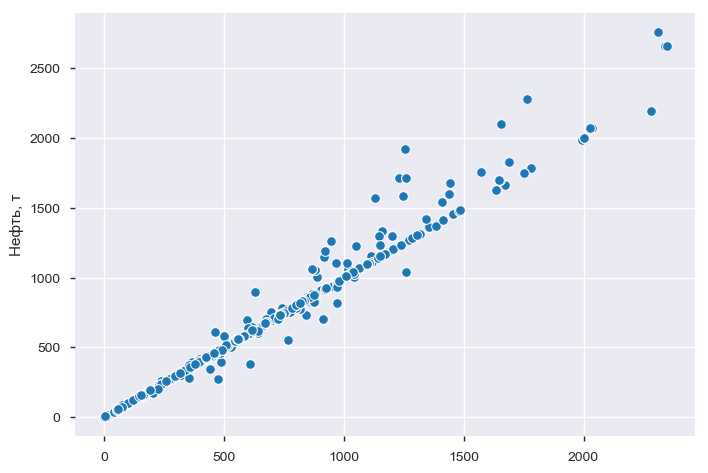

In [27]:
preds = mdl.get_test_eval()
sns.scatterplot(preds, Y_valid)

Как мы можем убедиться, в целом модель достаточно хорошо прогнозирует данные по уровню добычи нефти. При этом отчетливо видно, что основные ошибки прогнозирования отмечаются для скважин с высоким уровнем добычи нефти (эти данные расположены в "хвосте" распределения прогнозируемой переменной, т.е. они достаточно слабо представлены в обучающей выборке).

Далее выполним операцию подбора оптимальных гиперпараметров модели:

In [28]:
gridParams = {
    'learning_rate': [4, 6],
    'iterations': [2000],
    'objective' : ['MAE'],
    'depth' : [4, 6, 8]
    }

In [29]:
grid = GridSearchCV(mdl, gridParams,
                    cv=4)

In [51]:
#grid.fit(X_train, Y_train, cat_features=cat_features_indices, early_stopping_rounds=3, verbose=False)

## V. Интерпретация модели и выводы

Для интерпретации полученной модели построим график важности признаков:

In [43]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, mdl.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features_indices)))),
                columns=['Feature','Score'])

In [44]:
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

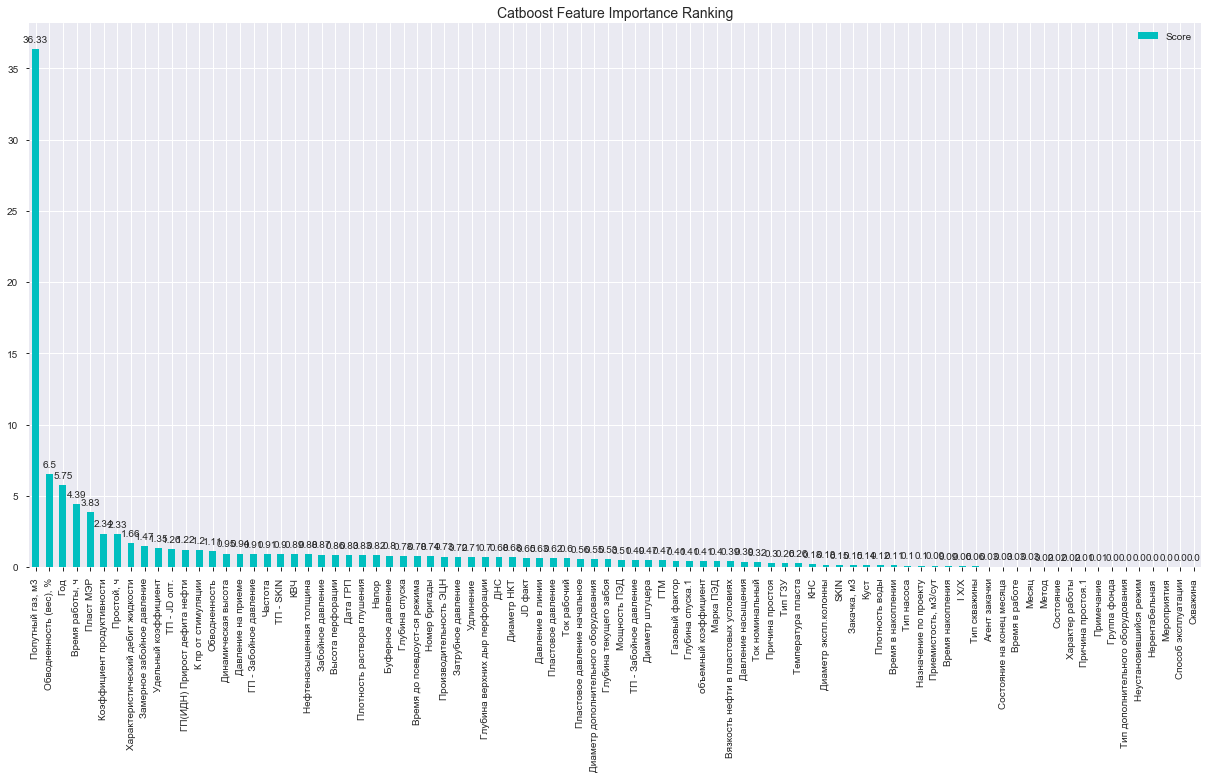

In [49]:
plt.rcParams["figure.figsize"] = (21,10)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

# get feature score as labels round to 2 decimal
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

Наиболее значимыми параметрами модели прогнозирования уровня добычи нефти оказались следующие признаки:
- Попутный газ;
- Обводненность;
- Год;
- Время работы;
- Пласт МЭР

В заключении данного отчета хотелось бы отметить следующие моменты:
    1. Для повышения качества прогнозного моделирования необходимо повышение качества ввода и сбора данных. Решение данной проблемы требует отдельного обследования,  
    но в общем случае она решается внедрением корпоративных систем MDM и Data Qouality;
    2. Не все передаваемые данные требуются для построения регрессионной модели, таким образом при внедрении модели в корпоративную архитектуру возможна оптимизация  
    информационного потока за счет включения в него только важных атрибутов;
    3. Возможно дальнейшее повышение качества полученной модели за счет привлечения новых данных, более углубленного анализа ошибок модели и расширенного подбора  
    гиперпараметров